## Conductivity mass balance for hydrograph separation

### Wade Brook, 2022 EXO specific conductivity dataset

#### Data were downloaded from Aquarius on 05.28.2024 (see Aquarius R notebook below)

    hhttps://github.com/MeganEDuffy/cQ_analysis/blob/main/md-notebooks/aquarius_data_download/Hford_Wade_spC_aquarius.ipynb

#### I also brought in discharge data from https://uvmoffice-my.sharepoint.com/personal/sblocher_uvm_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fsblocher%5Fuvm%5Fedu%2FDocuments%2FBREE%2FWatershed%20Data%2FStreams%2F02%5Fsite%5Fdata%2Fdischarge%2Fbest%5Fq

In [2]:
setwd("/home/millieginty/OneDrive/git-repos/cQ_analysis/")

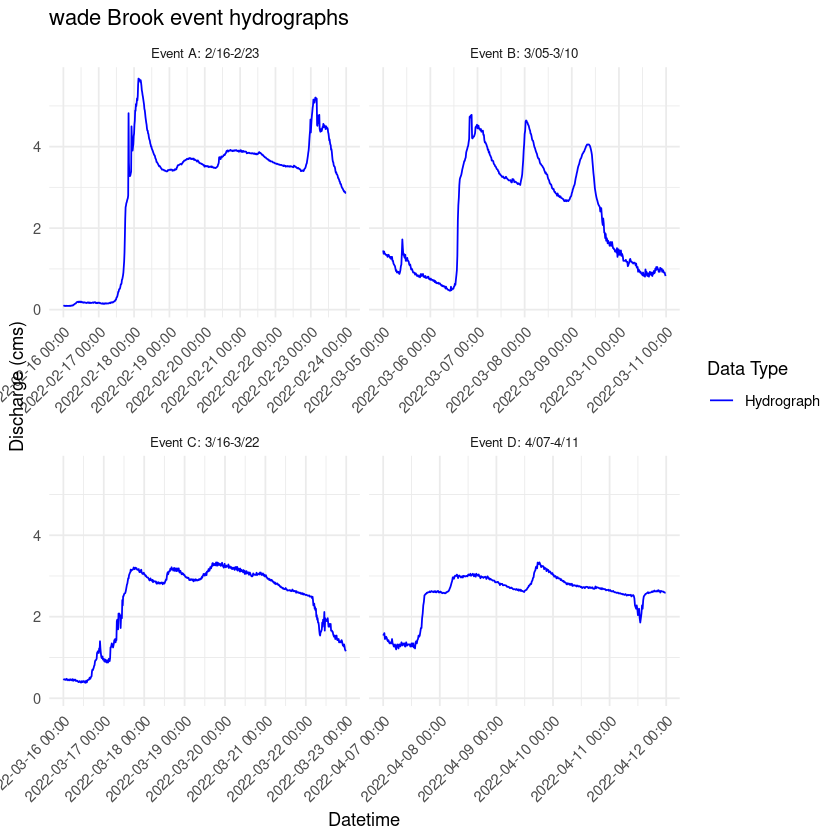

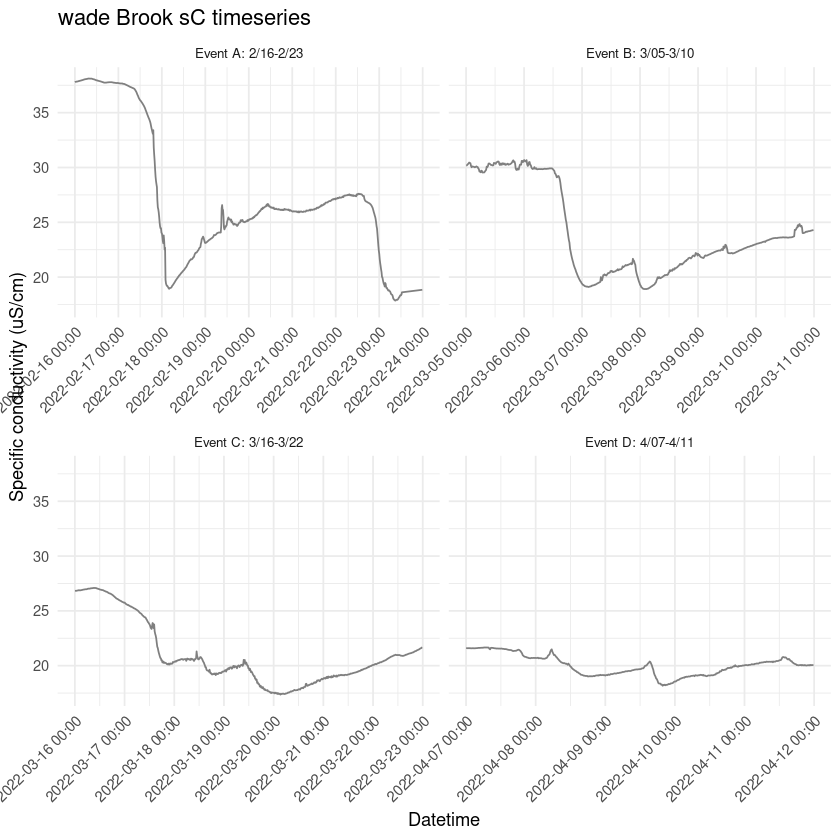

In [8]:
#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)
library(caTools)  # for numerical integration
library(data.table) # for nearest join of q and ISCO data

###################
# SET DIRECTORIES #
###################

input_dir <- "cond-hydrograph-separation/newrnet/data/"
output_dir <- "cond-hydrograph-separation/newrnet/output/"

################
# READ IN DATA #
################

# read in the streamwater ISCO data
InputDataEXO <- read.csv(file.path(input_dir, "wade_2022_sC_2024-06-12.csv"))

# read in the discharge data
InputDataQ <- read.csv(file.path(input_dir, "wade_2022_best_q_corr_MAT.csv"))

####################
# CLEAN THE DATA  #
####################

# Convert missing values to NA
InputDataEXO[InputDataEXO == ""] <- NA

# Rename specific conductivity column
InputDataEXO <- InputDataEXO %>% rename(sC = "Sp.Cond.SpecCond.Wade.Brook")

# Convert 'timestamp' in InputDataEXO to proper datetime format
InputDataEXO$timestamp <- ymd_hms(InputDataEXO$timestamp)

# Convert 'timestamp' in InputDataQ to proper datetime format
InputDataQ$timestamp <- mdy_hm(InputDataQ$r_timestamp)

# Convert dataframes to data.table
InputDataEXO_DT <- as.data.table(InputDataEXO)
InputDataQ_DT <- as.data.table(InputDataQ)

# Set keys for joining
setkey(InputDataEXO_DT, timestamp)
setkey(InputDataQ_DT, timestamp)

###############
# JOIN Q DATA #
###############

# Perform a nearest join using data.table
merged_data <- InputDataQ_DT[InputDataEXO_DT, roll = "nearest", on = .(timestamp = timestamp)]

# Save the merged dataframe to a csv
write.csv(merged_data, file.path(output_dir, "merged_data.csv"), row.names = FALSE)

########################
# SEPARATE INTO EVENTS #
########################

# Make sure date formatting all good
merged_data$Date <- as.Date(merged_data$timestamp) # Assuming Datetime is in POSIXct format

# Add Event column based on date ranges
merged_data <- merged_data %>%
  mutate(Event = case_when(
    Date >= as.Date('2022-02-16') & Date <= as.Date('2022-02-23') ~ 'Event A: 2/16-2/23',
    Date >= as.Date('2022-03-05') & Date <= as.Date('2022-03-10') ~ 'Event B: 3/05-3/10',
    Date >= as.Date('2022-03-16') & Date <= as.Date('2022-03-22') ~ 'Event C: 3/16-3/22',
    Date >= as.Date('2022-04-07') & Date <= as.Date('2022-04-11') ~ 'Event D: 4/07-4/11',
    TRUE ~ NA_character_ # Assign NA to dates outside the defined ranges
  ))

# Doing the same as above for the original Q data
InputDataQ$Date <- as.Date(InputDataQ$timestamp)

# Add Event column based on date ranges
InputDataQ <- InputDataQ %>%
  mutate(Event = case_when(
    Date >= as.Date('2022-02-16') & Date <= as.Date('2022-02-23') ~ 'Event A: 2/16-2/23',
    Date >= as.Date('2022-03-05') & Date <= as.Date('2022-03-10') ~ 'Event B: 3/05-3/10',
    Date >= as.Date('2022-03-16') & Date <= as.Date('2022-03-22') ~ 'Event C: 3/16-3/22',
    Date >= as.Date('2022-04-07') & Date <= as.Date('2022-04-11') ~ 'Event D: 4/07-4/11',
    TRUE ~ NA_character_ # Assign NA to dates outside the defined ranges
  ))

# Filter out rows where Event is NA
InputDataQ <- InputDataQ %>%
  filter(!is.na(Event))

# Doing the same as above for the original sC data
InputDataEXO$Date <- as.Date(InputDataEXO$timestamp)

# Add Event column based on date ranges
InputDataEXO <- InputDataEXO %>%
  mutate(Event = case_when(
    Date >= as.Date('2022-02-16') & Date <= as.Date('2022-02-23') ~ 'Event A: 2/16-2/23',
    Date >= as.Date('2022-03-05') & Date <= as.Date('2022-03-10') ~ 'Event B: 3/05-3/10',
    Date >= as.Date('2022-03-16') & Date <= as.Date('2022-03-22') ~ 'Event C: 3/16-3/22',
    Date >= as.Date('2022-04-07') & Date <= as.Date('2022-04-11') ~ 'Event D: 4/07-4/11',
    TRUE ~ NA_character_ # Assign NA to dates outside the defined ranges
  ))

# Filter out rows where Event is NA
InputDataEXO <- InputDataEXO %>%
  filter(!is.na(Event))

#######################
# PLOT THE HYDROGRAPH #
#######################

hydrograph_plot_InputDataQ <- ggplot() +
  geom_line(data = InputDataQ, aes(x = timestamp, y = best_q, color = "Hydrograph")) +
  theme_minimal() +
  labs(title = "wade Brook event hydrographs",
       x = "Datetime",
       y = "Discharge (cms)",
       color = "Data Type") +
  scale_x_datetime(date_labels = "%Y-%m-%d %H:%M", date_breaks = "1 day") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  facet_wrap(~ Event, scales = "free_x") +
  theme(strip.text = element_text(size = 8)) +
  scale_color_manual(values = c("Hydrograph" = "blue")) 

# Print the modified plot
print(hydrograph_plot_InputDataQ)

# Save the plot to a file
ggsave(file.path(output_dir, "storm_hydrograph_EXO.png"), hydrograph_plot_InputDataQ, width = 10, height = 6)

#######################
# PLOT THE CHEMOGRAPH #
#######################

chemograph_plot_InputDataEXO <- ggplot() +
  geom_line(data = InputDataEXO, aes(x = timestamp, y = sC,
  color = "Hydrograph")) +
  theme_minimal() +
  labs(title = "wade Brook sC timeseries",
       x = "Datetime",
       y = "Specific conductivity (uS/cm)",
       color = "Data Type") +
  scale_x_datetime(date_labels = "%Y-%m-%d %H:%M", date_breaks = "1 day") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  facet_wrap(~ Event, scales = "free_x") +
  theme(strip.text = element_text(size = 8)) +
  scale_color_manual(values = c("chemograph" = "blue")) 

# Print the modified plot
print(chemograph_plot_InputDataEXO)

# Save the plot to a file
ggsave(file.path(output_dir, "storm_chemograph_EXO.png"), chemograph_plot_InputDataEXO, width = 10, height = 6)


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


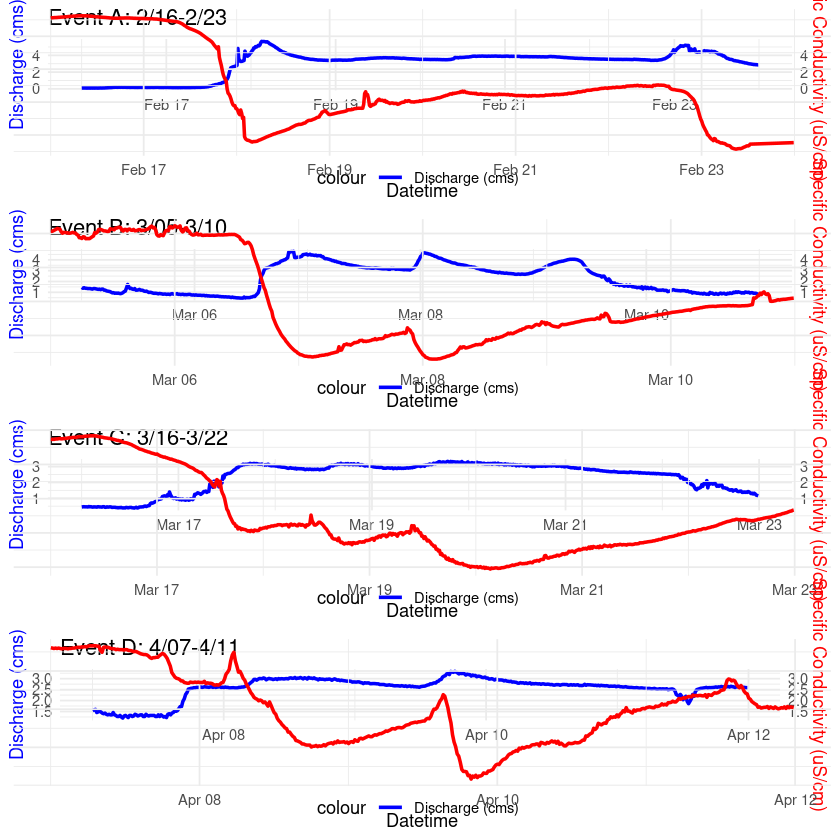

In [9]:
#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)
library(caTools)
library(data.table)
library(cowplot)

###################
# SET DIRECTORIES #
###################

input_dir <- "cond-hydrograph-separation/newrnet/data/"
output_dir <- "cond-hydrograph-separation/newrnet/output/"

################
# READ IN DATA #
################

# Read in the streamwater ISCO data
InputDataEXO <- read.csv(file.path(input_dir, "wade_2022_sC_2024-06-12.csv"))

# Read in the discharge data
InputDataQ <- read.csv(file.path(input_dir, "wade_2022_best_q_corr_MAT.csv"))

####################
# CLEAN THE DATA  #
####################

# Convert missing values to NA
InputDataEXO[InputDataEXO == ""] <- NA

# Convert 'timestamp' in InputDataEXO to proper datetime format
InputDataEXO$timestamp <- ymd_hms(InputDataEXO$timestamp)

# Rename specific conductivity column
InputDataEXO <- InputDataEXO %>% rename(sC = "Sp.Cond.SpecCond.Wade.Brook")

# Convert 'timestamp' in InputDataQ to proper datetime format
InputDataQ$timestamp <- mdy_hm(InputDataQ$r_timestamp)

# Convert dataframes to data.table
InputDataEXO_DT <- as.data.table(InputDataEXO)
InputDataQ_DT <- as.data.table(InputDataQ)

# Set keys for joining
setkey(InputDataEXO_DT, timestamp)
setkey(InputDataQ_DT, timestamp)

###############
# JOIN Q DATA #
###############

# Perform a nearest join using data.table
merged_data <- InputDataQ_DT[InputDataEXO_DT, roll = "nearest", on = .(timestamp = timestamp)]

# Save the merged dataframe to a csv
write.csv(merged_data, file.path(output_dir, "merged_data.csv"), row.names = FALSE)

########################
# SEPARATE INTO EVENTS #
########################

# Ensure date formatting is correct
merged_data$Date <- as.Date(merged_data$timestamp)

# Add Event column based on date ranges
merged_data <- merged_data %>%
  mutate(Event = case_when(
    Date >= as.Date('2022-02-16') & Date <= as.Date('2022-02-23') ~ 'Event A: 2/16-2/23',
    Date >= as.Date('2022-03-05') & Date <= as.Date('2022-03-10') ~ 'Event B: 3/05-3/10',
    Date >= as.Date('2022-03-16') & Date <= as.Date('2022-03-22') ~ 'Event C: 3/16-3/22',
    Date >= as.Date('2022-04-07') & Date <= as.Date('2022-04-11') ~ 'Event D: 4/07-4/11',
    TRUE ~ NA_character_
  ))

# Filter out rows where Event is NA
merged_data <- merged_data %>%
  filter(!is.na(Event))

#######################
# PLOT THE HYDROGRAPH #
#######################

# Function to create dual-axis plots
create_event_plot <- function(event_data, event_name) {
  p1 <- ggplot(event_data, aes(x = timestamp)) +
    geom_line(aes(y = best_q, color = "Discharge (cms)"), size = 1) +
    scale_y_continuous(name = "Discharge (cms)", sec.axis = sec_axis(~ ., name = "Specific Conductivity (uS/cm)")) +
    scale_color_manual(values = c("Discharge (cms)" = "blue", "Specific Conductivity (uS/cm)" = "red")) +
    theme_minimal() +
    theme(
      axis.title.y.left = element_text(color = "blue"),
      axis.title.y.right = element_text(color = "red"),
      legend.position = "bottom"
    ) +
    labs(title = event_name, x = "", y = "")

  p2 <- ggplot(event_data, aes(x = timestamp)) +
    geom_line(aes(y = sC, color = "Specific Conductivity (uS/cm)"), size = 1) +
    scale_color_manual(values = c("Discharge (cms)" = "blue", "Specific Conductivity (uS/cm)" = "red")) +
    theme_minimal() +
    theme(
      axis.title.y = element_blank(),
      axis.text.y = element_blank(),
      axis.ticks.y = element_blank(),
      legend.position = "none"
    ) +
    labs(x = "Datetime")

  combined_plot <- ggdraw() +
    draw_plot(p1) +
    draw_plot(p2, 0, 0, 1, 1) +
    draw_plot_label(c("", ""), x = 0.5, y = 0.5, color = c("blue", "red"), angle = 90)

  return(combined_plot)
}

# Generate plots for each event
event_plots <- merged_data %>%
  split(.$Event) %>%
  map2(names(.), ~ create_event_plot(.x, .y))

# Combine event plots into one
final_plot <- plot_grid(plotlist = event_plots, ncol = 1)

# Print and save the combined plot
print(final_plot)
ggsave(file.path(output_dir, "combined_storm_hydrograph_chemograph.png"), final_plot, width = 10, height = 12)

## Conductivity mass balance

### where old water is lowest sC just preceding event

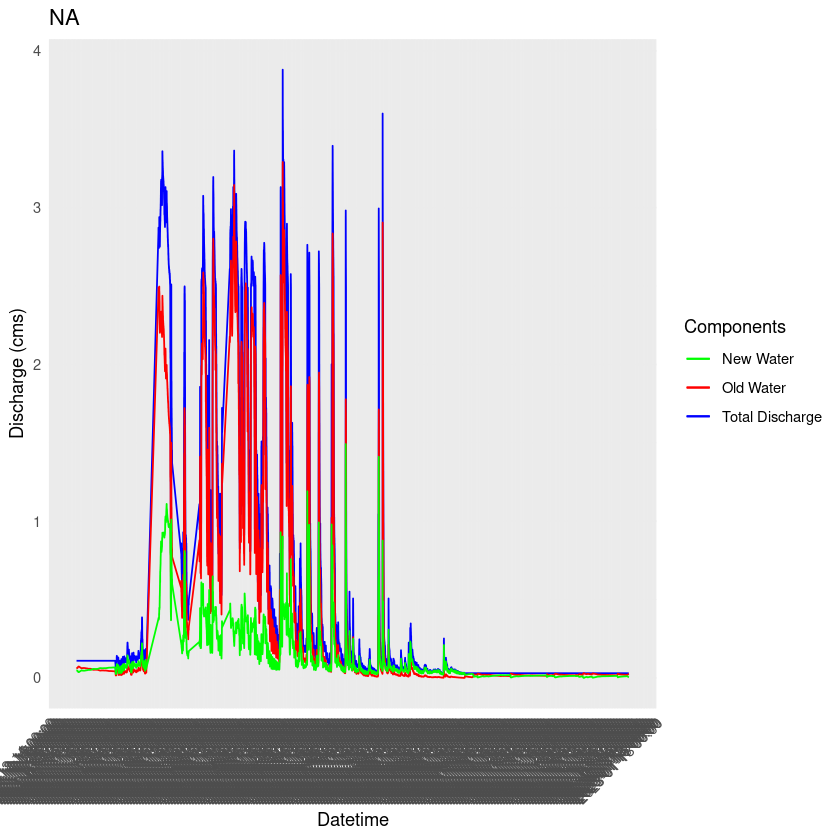

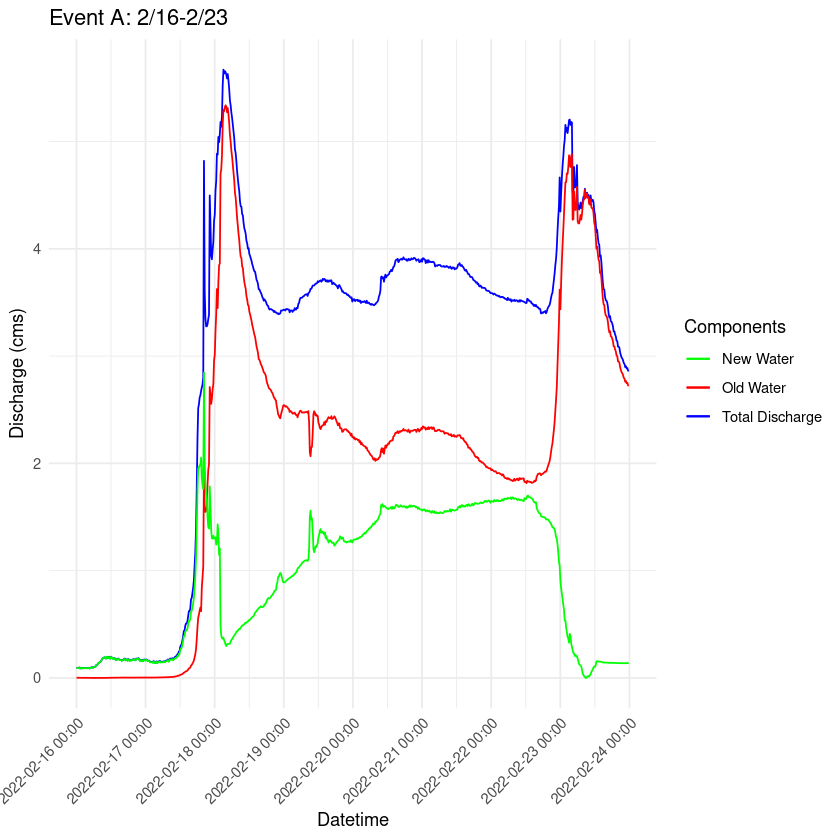

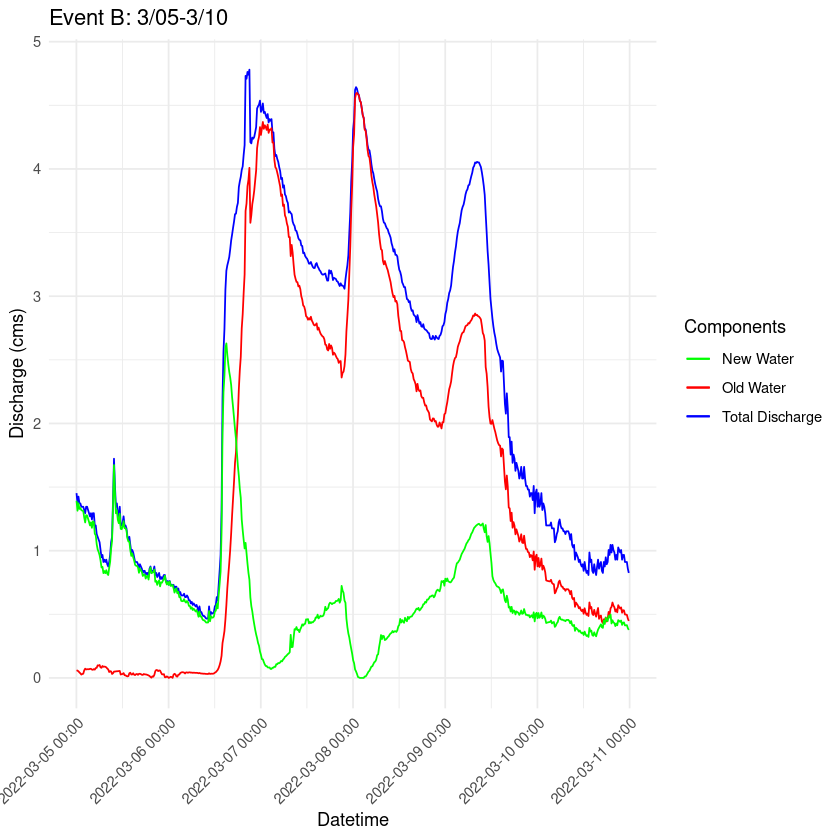

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]


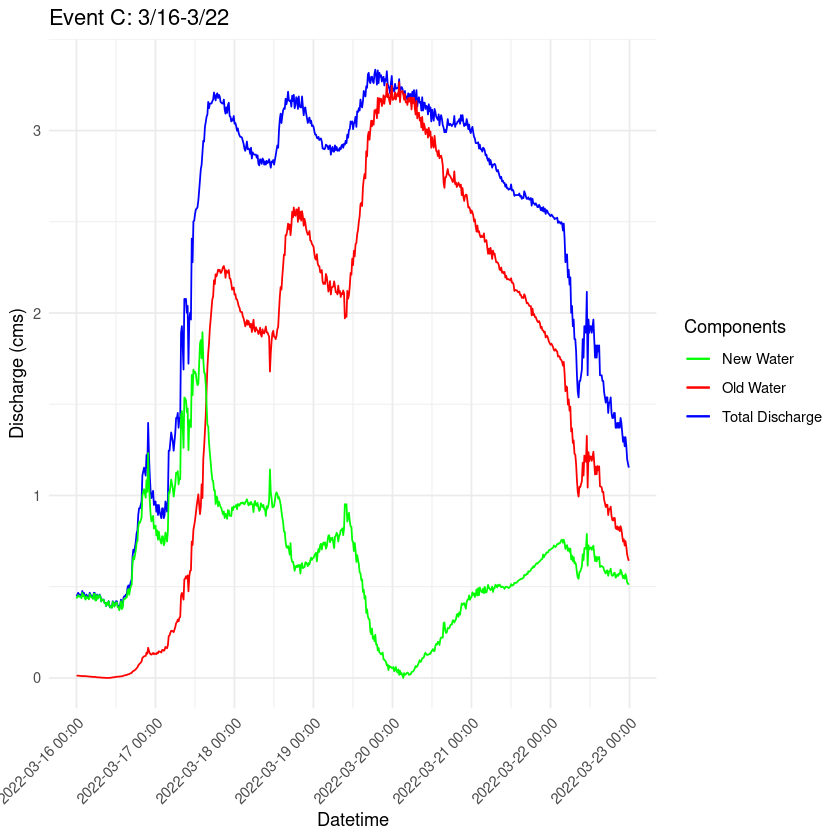

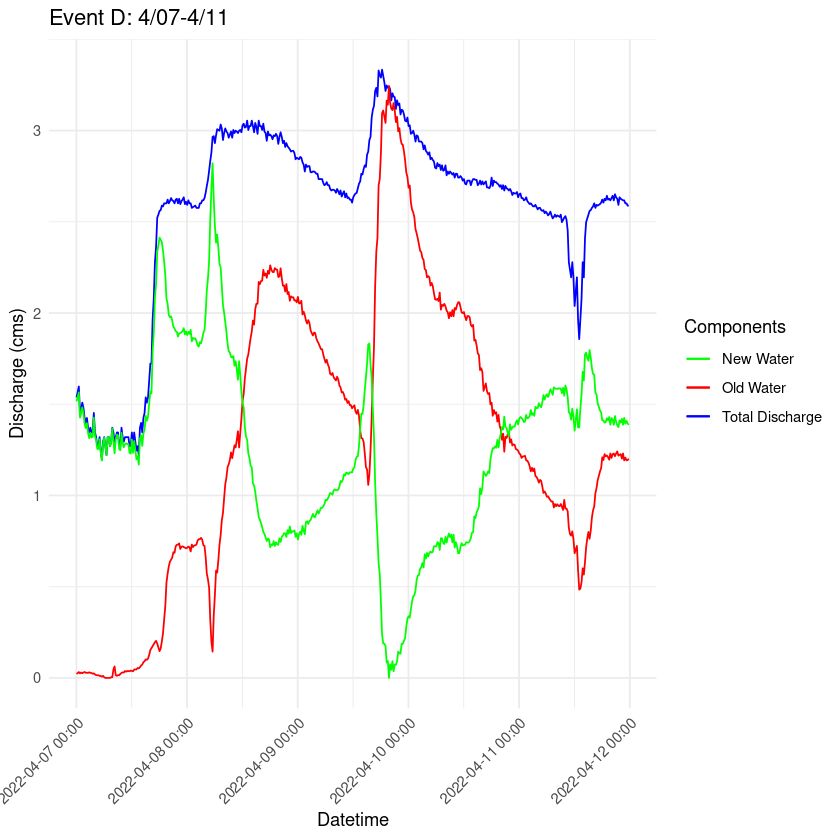

In [10]:
#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)
library(caTools)  # for numerical integration
library(data.table) # for nearest join of q and ISCO data

###################
# SET DIRECTORIES #
###################

input_dir <- "cond-hydrograph-separation/newrnet/data/"
output_dir <- "cond-hydrograph-separation/newrnet/output/"

################
# READ IN DATA #
################

# read in the streamwater ISCO data
InputDataEXO <- read.csv(file.path(input_dir, "wade_2022_sC_2024-06-12.csv"))

# read in the discharge data
InputDataQ <- read.csv(file.path(input_dir, "wade_2022_best_q_corr_MAT.csv"))

####################
# CLEAN THE DATA  #
####################

# Convert missing values to NA
InputDataEXO[InputDataEXO == ""] <- NA

# Rename specific conductivity column
InputDataEXO <- InputDataEXO %>% rename(sC = "Sp.Cond.SpecCond.Wade.Brook")

# Convert 'timestamp' in InputDataEXO to proper datetime format
InputDataEXO$timestamp <- ymd_hms(InputDataEXO$timestamp)

# Convert 'timestamp' in InputDataQ to proper datetime format
InputDataQ$timestamp <- mdy_hm(InputDataQ$r_timestamp)

# Convert dataframes to data.table
InputDataEXO_DT <- as.data.table(InputDataEXO)
InputDataQ_DT <- as.data.table(InputDataQ)

# Set keys for joining
setkey(InputDataEXO_DT, timestamp)
setkey(InputDataQ_DT, timestamp)

###############
# JOIN Q DATA #
###############

# Perform a nearest join using data.table
merged_data <- InputDataQ_DT[InputDataEXO_DT, roll = "nearest", on = .(timestamp = timestamp)]

# Save the merged dataframe to a csv
write.csv(merged_data, file.path(output_dir, "merged_data.csv"), row.names = FALSE)

########################
# SEPARATE INTO EVENTS #
########################

# Make sure date formatting all good
merged_data$Date <- as.Date(merged_data$timestamp) # Assuming Datetime is in POSIXct format

# Add Event column based on date ranges
merged_data <- merged_data %>%
  mutate(Event = case_when(
    Date >= as.Date('2022-02-16') & Date <= as.Date('2022-02-23') ~ 'Event A: 2/16-2/23',
    Date >= as.Date('2022-03-05') & Date <= as.Date('2022-03-10') ~ 'Event B: 3/05-3/10',
    Date >= as.Date('2022-03-16') & Date <= as.Date('2022-03-22') ~ 'Event C: 3/16-3/22',
    Date >= as.Date('2022-04-07') & Date <= as.Date('2022-04-11') ~ 'Event D: 4/07-4/11',
    TRUE ~ NA_character_ # Assign NA to dates outside the defined ranges
  ))

# Doing the same as above for the original Q data
InputDataQ$Date <- as.Date(InputDataQ$timestamp)

# Add Event column based on date ranges
InputDataQ <- InputDataQ %>%
  mutate(Event = case_when(
    Date >= as.Date('2022-02-16') & Date <= as.Date('2022-02-23') ~ 'Event A: 2/16-2/23',
    Date >= as.Date('2022-03-05') & Date <= as.Date('2022-03-10') ~ 'Event B: 3/05-3/10',
    Date >= as.Date('2022-03-16') & Date <= as.Date('2022-03-22') ~ 'Event C: 3/16-3/22',
    Date >= as.Date('2022-04-07') & Date <= as.Date('2022-04-11') ~ 'Event D: 4/07-4/11',
    TRUE ~ NA_character_ # Assign NA to dates outside the defined ranges
  ))

# Filter out rows where Event is NA
InputDataQ <- InputDataQ %>%
  filter(!is.na(Event))

# Nest data by Event
nested_data <- merged_data %>%
  group_by(Event) %>%
  nest()

# Create a function to calculate new and old water proportions and plot the hydrograph
process_event <- function(data, event_name) {
  # Set new and old water values based on the highest and lowest sC values during the event
  Event_new <- max(data$sC, na.rm = TRUE)
  Event_old <- min(data$sC, na.rm = TRUE)
  
  # Calculate Q_o(t) using Equation 3
  data <- data %>%
    mutate(Q_o = `best_q` * (`sC` - Event_new) / (Event_old - Event_new),
           Q_n = `best_q` - Q_o)
  
  # Plot using ggplot2
  hydrograph_plot <- ggplot(data, aes(x = timestamp)) +
    geom_line(aes(y = best_q, color = "Total Discharge")) +
    geom_line(aes(y = Q_o, color = "Old Water")) +
    geom_line(aes(y = Q_n, color = "New Water")) +
    scale_color_manual(values = c("Total Discharge" = "blue", "Old Water" = "red", "New Water" = "green")) +
    theme_minimal() +
    labs(title = event_name,
         x = "Datetime",
         y = "Discharge (cms)",
         color = "Components") +
    scale_x_datetime(date_labels = "%Y-%m-%d %H:%M", date_breaks = "1 day") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
  
  # Save the plot to a file
  ggsave(file.path(output_dir, paste0("storm_hydrograph_", gsub("[: ]", "_", event_name), ".png")), hydrograph_plot, width = 10, height = 6)
  
  return(hydrograph_plot)
}

# Apply the function to each event
plots <- nested_data %>%
  mutate(plot = map2(data, Event, ~ process_event(.x, .y)))

# Print all plots
plots$plot

### Now the Event_old is the lowest sC over the entire dataset:

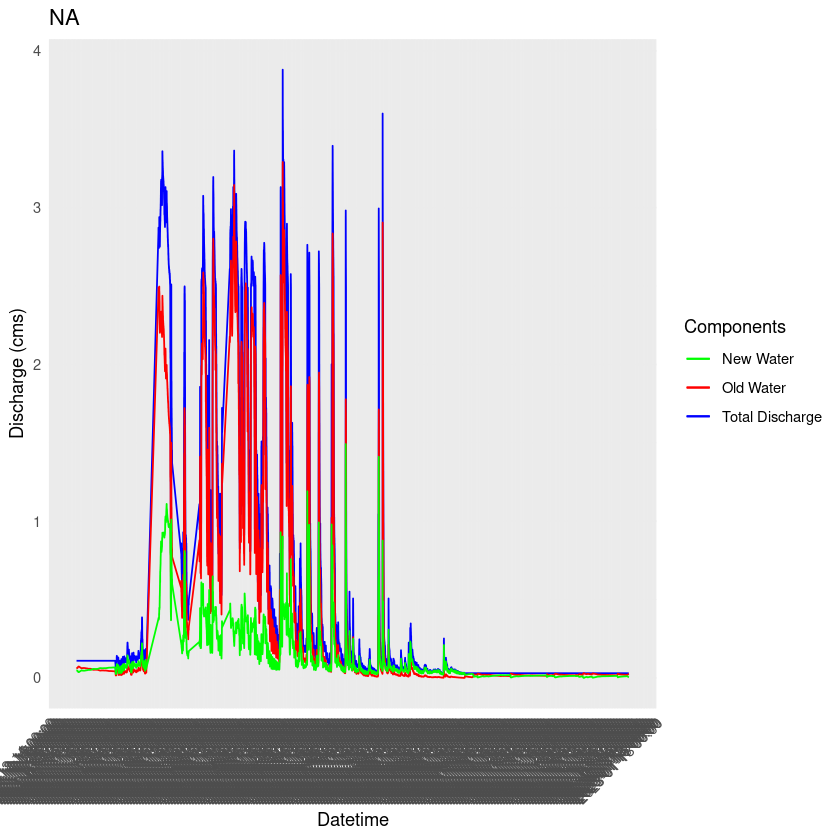

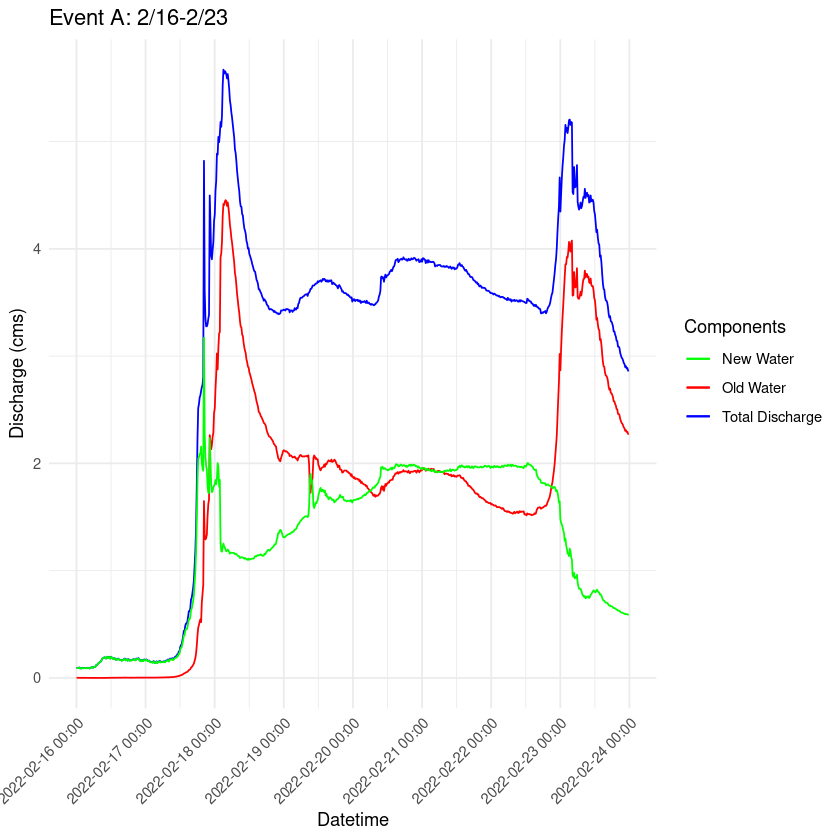

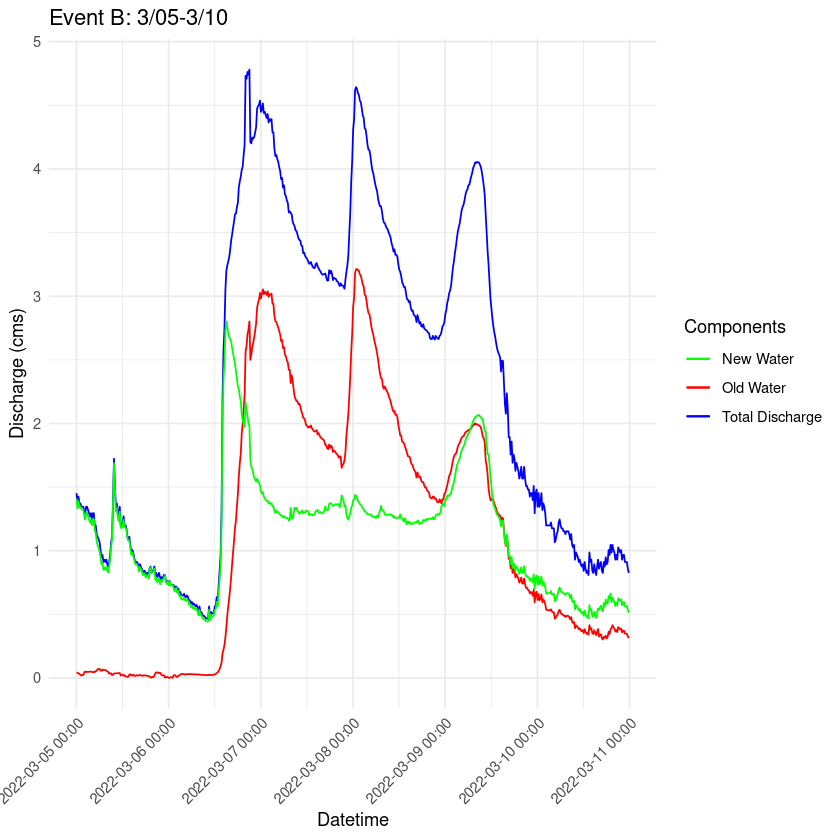

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]


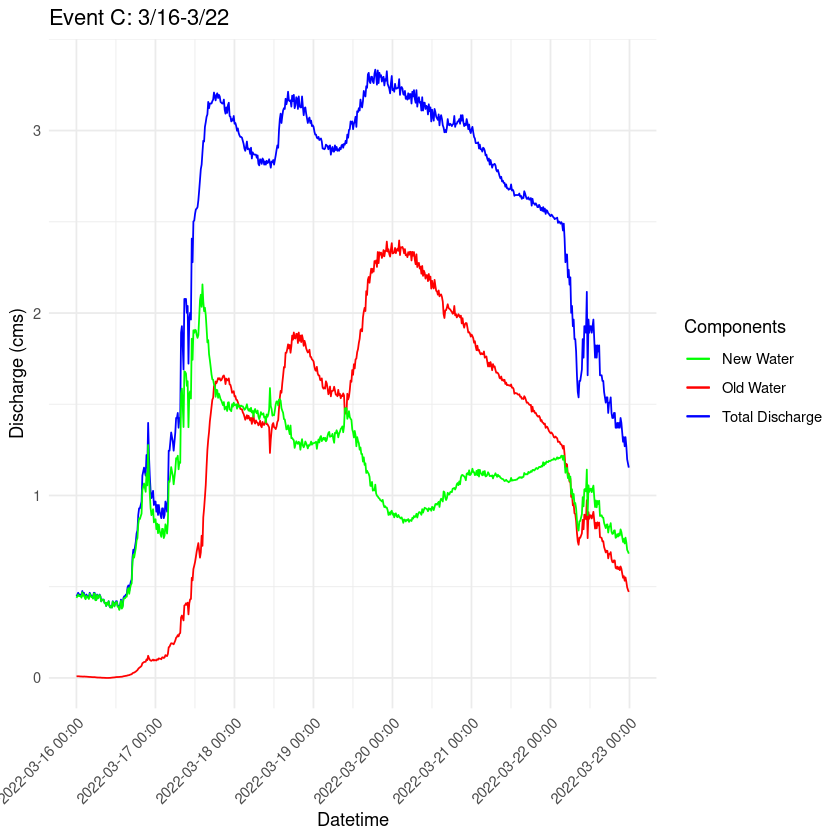

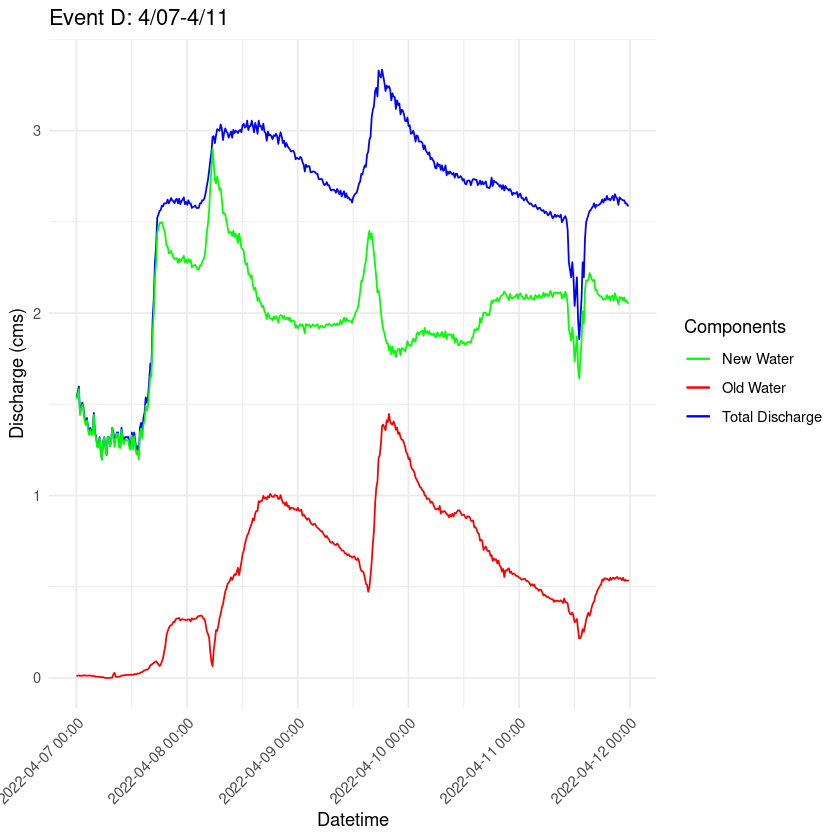

In [11]:
#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)
library(caTools)  # for numerical integration
library(data.table) # for nearest join of q and ISCO data

###################
# SET DIRECTORIES #
###################

input_dir <- "cond-hydrograph-separation/newrnet/data/"
output_dir <- "cond-hydrograph-separation/newrnet/output/"

################
# READ IN DATA #
################

# read in the streamwater ISCO data
InputDataEXO <- read.csv(file.path(input_dir, "wade_2022_sC_2024-06-12.csv"))

# read in the discharge data
InputDataQ <- read.csv(file.path(input_dir, "wade_2022_best_q_corr_MAT.csv"))

####################
# CLEAN THE DATA  #
####################

# Convert missing values to NA
InputDataEXO[InputDataEXO == ""] <- NA

# Rename specific conductivity column
InputDataEXO <- InputDataEXO %>% rename(sC = "Sp.Cond.SpecCond.Wade.Brook")

# Convert 'timestamp' in InputDataEXO to proper datetime format
InputDataEXO$timestamp <- ymd_hms(InputDataEXO$timestamp)

# Convert 'timestamp' in InputDataQ to proper datetime format
InputDataQ$timestamp <- mdy_hm(InputDataQ$r_timestamp)

# Convert dataframes to data.table
InputDataEXO_DT <- as.data.table(InputDataEXO)
InputDataQ_DT <- as.data.table(InputDataQ)

# Set keys for joining
setkey(InputDataEXO_DT, timestamp)
setkey(InputDataQ_DT, timestamp)

###############
# JOIN Q DATA #
###############

# Perform a nearest join using data.table
merged_data <- InputDataQ_DT[InputDataEXO_DT, roll = "nearest", on = .(timestamp = timestamp)]

# Save the merged dataframe to a csv
write.csv(merged_data, file.path(output_dir, "merged_data.csv"), row.names = FALSE)

########################
# SEPARATE INTO EVENTS #
########################

# Make sure date formatting all good
merged_data$Date <- as.Date(merged_data$timestamp) # Assuming Datetime is in POSIXct format

# Add Event column based on date ranges
merged_data <- merged_data %>%
  mutate(Event = case_when(
    Date >= as.Date('2022-02-16') & Date <= as.Date('2022-02-23') ~ 'Event A: 2/16-2/23',
    Date >= as.Date('2022-03-05') & Date <= as.Date('2022-03-10') ~ 'Event B: 3/05-3/10',
    Date >= as.Date('2022-03-16') & Date <= as.Date('2022-03-22') ~ 'Event C: 3/16-3/22',
    Date >= as.Date('2022-04-07') & Date <= as.Date('2022-04-11') ~ 'Event D: 4/07-4/11',
    TRUE ~ NA_character_ # Assign NA to dates outside the defined ranges
  ))

# Doing the same as above for the original Q data
InputDataQ$Date <- as.Date(InputDataQ$timestamp)

# Add Event column based on date ranges
InputDataQ <- InputDataQ %>%
  mutate(Event = case_when(
    Date >= as.Date('2022-02-16') & Date <= as.Date('2022-02-23') ~ 'Event A: 2/16-2/23',
    Date >= as.Date('2022-03-05') & Date <= as.Date('2022-03-10') ~ 'Event B: 3/05-3/10',
    Date >= as.Date('2022-03-16') & Date <= as.Date('2022-03-22') ~ 'Event C: 3/16-3/22',
    Date >= as.Date('2022-04-07') & Date <= as.Date('2022-04-11') ~ 'Event D: 4/07-4/11',
    TRUE ~ NA_character_ # Assign NA to dates outside the defined ranges
  ))

# Filter out rows where Event is NA
InputDataQ <- InputDataQ %>%
  filter(!is.na(Event))

# Calculate the lowest sC value for the entire dataset
overall_min_sC <- min(merged_data$sC, na.rm = TRUE)

# Nest data by Event
nested_data <- merged_data %>%
  group_by(Event) %>%
  nest()

# Create a function to calculate new and old water proportions and plot the hydrograph
process_event <- function(data, event_name, overall_min_sC) {
  # Set new water value based on the highest sC value during the event
  Event_new <- max(data$sC, na.rm = TRUE)
  # Set old water value based on the lowest sC value for the entire dataset
  Event_old <- overall_min_sC
  
  # Calculate Q_o(t) using Equation 3
  data <- data %>%
    mutate(Q_o = `best_q` * (`sC` - Event_new) / (Event_old - Event_new),
           Q_n = `best_q` - Q_o)
  
  # Plot using ggplot2
  hydrograph_plot <- ggplot(data, aes(x = timestamp)) +
    geom_line(aes(y = best_q, color = "Total Discharge")) +
    geom_line(aes(y = Q_o, color = "Old Water")) +
    geom_line(aes(y = Q_n, color = "New Water")) +
    scale_color_manual(values = c("Total Discharge" = "blue", "Old Water" = "red", "New Water" = "green")) +
    theme_minimal() +
    labs(title = event_name,
         x = "Datetime",
         y = "Discharge (cms)",
         color = "Components") +
    scale_x_datetime(date_labels = "%Y-%m-%d %H:%M", date_breaks = "1 day") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
  
  # Save the plot to a file
  ggsave(file.path(output_dir, paste0("storm_hydrograph_", gsub("[: ]", "_", event_name), ".png")), hydrograph_plot, width = 10, height = 6)
  
  return(hydrograph_plot)
}

# Apply the function to each event
plots <- nested_data %>%
  mutate(plot = map2(data, Event, ~ process_event(.x, .y, overall_min_sC)))

# Print all plots
plots$plot